## Training Functions

### Plot graph

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.colors import Normalize
import torch
import os

def plot_evolution(w_Cs, w_A, window_size=20):
    w_A = np.convolve(w_A, np.ones(window_size), 'valid') / window_size
    time = np.linspace(0, 1, len(w_A))

    w_Cs = np.array(w_Cs)
    w_Cs = w_Cs.T

    fig, ax = plt.subplots(figsize=(8, 6))
    
    for w_C in w_Cs:
        # smooth the data with a moving average
        w_C = np.convolve(w_C, np.ones(window_size), 'valid') / window_size
        # Create segments for the line
        points = np.array([w_A, w_C]).T.reshape(-1, 1, 2)
        segments = np.concatenate([points[:-1], points[1:]], axis=1)

        # Create a line collection
        norm = Normalize(vmin=time.min(), vmax=time.max())  # Normalize time values
        lc = LineCollection(segments, cmap="viridis", norm=norm, alpha=0.7)
        lc.set_array(time)  # Use time to color the line
        ax.add_collection(lc)

        # plot initial and final points
        ax.scatter(w_A[0], w_C[0], c='r', alpha=1, zorder=10)
        ax.scatter(w_A[-1], w_C[-1], c='b', alpha=1, zorder=10)
   
        
    ax.autoscale()  # Adjust axis limits
    ax.set_xlabel("W_A")
    ax.set_ylabel("W_C")
    ax.grid(True) 
    

    # Add a colorbar to show time progression
    cbar = plt.colorbar(lc, ax=ax)
    cbar.set_label("Time")
    
    ax.set_title("Final result: {:.3f}".format(np.mean(w_Cs[:, -1])))
    plt.show()

## SHD

In [2]:
import torch
import torch.nn as nn
from aihwkit.nn import AnalogLinear
from aihwkit.simulator.presets import EcRamPreset
from aihwkit.optim import AnalogSGD

rpu_config = EcRamPreset()

# rpu_config.device.gamma_up = 0.01153
# rpu_config.device.gamma_down = 0.05085


# Define two parallel networks
class Network(nn.Module):
    def __init__(self, device='cpu', rpu_config=rpu_config):
        super(Network, self).__init__()
        self.l1 = AnalogLinear(1, 1, bias=False, rpu_config=rpu_config).to(device)

    def forward(self, x):
        x = self.l1(x)
        return x

model = Network()
   
for param in model.parameters():
    analog_tile = param.analog_tile
    # Access the TransferCompound device
    device_weights = analog_tile.get_hidden_parameters()
    for key, value in device_weights.items():
        print(f"{key}: {value}")

max_bound: tensor([[1.1227]])
min_bound: tensor([[-0.8106]])
dwmin_up: tensor([[0.0018]])
dwmin_down: tensor([[0.0019]])
decay_scales: tensor([[1.]])
diffusion_rates: tensor([[0.]])
reset_bias: tensor([[0.]])
drift_nu: tensor([[0.]])
slope_up: tensor([[-3.4449e-05]])
slope_down: tensor([[0.0010]])


In [3]:
params = model.l1.analog_module.get_hidden_parameters()
params

OrderedDict([('max_bound', tensor([[1.1227]])),
             ('min_bound', tensor([[-0.8106]])),
             ('dwmin_up', tensor([[0.0018]])),
             ('dwmin_down', tensor([[0.0019]])),
             ('decay_scales', tensor([[1.]])),
             ('diffusion_rates', tensor([[0.]])),
             ('reset_bias', tensor([[0.]])),
             ('drift_nu', tensor([[0.]])),
             ('slope_up', tensor([[-3.4449e-05]])),
             ('slope_down', tensor([[0.0010]]))])

## Training

In [4]:
from IPython.display import clear_output

def test_evaluation(model, val_set, classifier):
    """Test trained network

    Args:
        model (nn.Model): Trained model to be evaluated
        val_set (DataLoader): Validation set to perform the evaluation
    """
    # Setup counter of images predicted to 0.
    total_loss = 0
    predicted_ok = 0
    total_images = 0

    model.eval()

    for images, labels in val_set:
        images = images.view(images.shape[0], -1)
        pred = model(images)

        loss = classifier(pred, labels)

        total_loss += loss.item() * labels.size(0)
        _, predicted = torch.max(pred.data, 1)
        total_images += labels.size(0)
        predicted_ok += (predicted == labels).sum().item()

    accuracy = predicted_ok / total_images
    loss = total_loss / total_images
    return loss, accuracy

def training_run(train_set, validation_set, model, swa_tracker, optimizer, scheduler, loss_fn, epochs):

    l = []
    a = []
    num_tiles = model.l1.rpu_config.batch_size
    
    for e in range(epochs):
        model.train()

        for x, y_true in train_set:
            # Flatten MNIST images into a 784 vector.
            x = x.view(x.shape[0], -1)
            
            
            output = model(x)
            # Compute loss
            loss = loss_fn(output, y_true)

            # regroup output and target to compute tile specific losses
            # Calculate inputs per tile as in the forward pass
            batch_size = x.shape[0]
            inputs_per_tile = (batch_size + num_tiles - 1) // num_tiles

            # Initialize list for tile losses
            tile_losses = []

            # Calculate loss for each tile using the same distribution logic
            for i in range(num_tiles):
                # Get the start and end indices for this tile
                start_idx = i * inputs_per_tile
                end_idx = min(start_idx + inputs_per_tile, batch_size)
                
                # Skip if this tile didn't receive any inputs
                if start_idx >= batch_size:
                    continue
                    
                # Get outputs and targets for this tile
                tile_output = output[start_idx:end_idx]
                tile_target = y_true[start_idx:end_idx]
                
                # Calculate loss
                tile_loss = loss_fn(tile_output, tile_target)
                tile_losses.append(tile_loss.item())
                
                # Update running loss average
                swa_tracker.update_tile_loss(i, tile_loss.item())

            # backward pass
            loss.backward()

            # update params
            optimizer.step()
            optimizer.zero_grad()

        model.digitize_model()
        loss, acc = test_evaluation(model, validation_set, loss_fn)
        l.append(loss)
        a.append(acc)

         # Update SWA tracker
        swa_tracker.update(e, collect_performance=True)

        # Decay learning rate if needed.
        # if acc > 0.90 and scheduler.get_last_lr()[0] >= 0.1 \
        #     or acc > 0.95 and scheduler.get_last_lr()[0] >= 0.05:
        #     print("Decaying learning rate from {} to {}".format(scheduler.get_last_lr()[0], scheduler.get_last_lr()[0] * 0.5))
        #     scheduler.step()

        if (e+1) % 1 == 0:
            clear_output(wait=True)
            plt.plot(l)
            plt.title(f'Final Loss: {np.mean(l[-1:]):.2f}')
            plt.xlabel('Epoch')
            plt.ylabel('Loss')
            plt.show()
            if a != []:
                plt.plot(a)
                plt.title(f'Final Accuracy: {np.mean(a[-1:]):.2f}')
                plt.xlabel('Epoch')
                plt.ylabel('Accuracy')
                plt.show()
        
        if np.isnan(l[-1]):
            break

    return l, a


### MNIST


In [5]:
from aihwkit.simulator.tiles.transfer_for_batched_TTv2 import TorchTransferTile
from aihwkit.optim import AnalogSGD
import torch.nn as nn
from aihwkit.nn import AnalogLinear
from aihwkit.simulator.presets import AGADEcRamPreset
from torch.optim.lr_scheduler import StepLR

# Network definition.
INPUT_SIZE = 784
HIDDEN_SIZES = [256, 128]
OUTPUT_SIZE = 10

class Analog_Network(nn.Module):

    def __init__(self, rpu_config, t = [1,1,1], init_std=0.0):
        super(Analog_Network, self).__init__()

        rpu_config.device.units_in_mbatch = True
        rpu_config.mapping.learn_out_scaling = True
        rpu_config.device.transfer_every = t[0]
        self.l1 = TorchTransferTile(
            INPUT_SIZE,
            HIDDEN_SIZES[0],
            rpu_config,
            True,
        )
        rpu_config.device.transfer_every = t[1]
        self.l2 = TorchTransferTile(
            HIDDEN_SIZES[0],
            HIDDEN_SIZES[1],
            rpu_config,
            True,
        )
        rpu_config.device.transfer_every = t[2]
        self.l3 = TorchTransferTile(
            HIDDEN_SIZES[1],
            OUTPUT_SIZE,
            rpu_config,
            True,
        )
        self.logsoftmax = nn.LogSoftmax(dim=1)

        # self.l1.set_scales(torch.tensor([5.0]))
        # self.l2.set_scales(torch.tensor([5.0]))
        # self.l3.set_scales(torch.tensor([3.0]))

        if init_std >= 0:
            batch_size = self.l1.rpu_config.batch_size
            # initialize weights  
            init_w = torch.nn.init.xavier_normal_(self.l1.get_weights()[0][0])
            noisy_weights = [torch.normal(mean=init_w, std=init_std) for _ in range(batch_size)]
            params = self.l1.get_hidden_parameters()
            params.update({f'slow_weight_{i+1}': noisy_weights[i] for i in range(batch_size)})
            params.update({f'fast_weight': torch.zeros_like(init_w)})
            #params.update({f'fast_weight_{i+1}': torch.zeros_like(init_w) for i in range(batch_size)})
            self.l1.set_hidden_parameters(params)

            init_w = torch.nn.init.xavier_normal_(self.l2.get_weights()[0][0])
            noisy_weights = [torch.normal(mean=init_w, std=init_std) for _ in range(batch_size)]
            params = self.l2.get_hidden_parameters()
            params.update({f'slow_weight_{i+1}': noisy_weights[i] for i in range(batch_size)})
            params.update({f'fast_weight': torch.zeros_like(init_w)})
            #params.update({f'fast_weight_{i+1}': torch.zeros_like(init_w) for i in range(batch_size)})
            self.l2.set_hidden_parameters(params)  

            init_w = torch.nn.init.xavier_normal_(self.l3.get_weights()[0][0])
            noisy_weights = [torch.normal(mean=init_w, std=init_std) for _ in range(batch_size)]
            params = self.l3.get_hidden_parameters()
            params.update({f'slow_weight_{i+1}': noisy_weights[i] for i in range(batch_size)})
            params.update({f'fast_weight': torch.zeros_like(init_w)})
            #params.update({f'fast_weight_{i+1}': torch.zeros_like(init_w) for i in range(batch_size)})
            self.l3.set_hidden_parameters(params)


    def digitize_model(self):
        w_l1 = torch.mean(self.l1.get_weights()[0], dim=0)
        w_l2 = torch.mean(self.l2.get_weights()[0], dim=0)
        w_l3 = torch.mean(self.l3.get_weights()[0], dim=0)
        self.l1_n = nn.Linear(INPUT_SIZE, HIDDEN_SIZES[0], bias=True)
        self.l1_n.weight.data = w_l1
        self.l1_n.bias.data = self.l1.get_weights()[1]
        self.l2_n = nn.Linear(HIDDEN_SIZES[0], HIDDEN_SIZES[1], bias=True)
        self.l2_n.weight.data = w_l2
        self.l2_n.bias.data = self.l2.get_weights()[1]
        self.l3_n = nn.Linear(HIDDEN_SIZES[1], OUTPUT_SIZE, bias=True)
        self.l3_n.weight.data = w_l3
        self.l3_n.bias.data = self.l3.get_weights()[1]

    def forward(self, x):
        if self.training:
            x = self.l1(x)
            x = torch.sigmoid(x)
            x = self.l2(x)
            x = torch.sigmoid(x)
            x = self.l3(x)
            x = self.logsoftmax(x)
            return x 
        else:
            with torch.no_grad():
                x = self.l1_n(x)
                x = torch.sigmoid(x)
                x = self.l2_n(x)
                x = torch.sigmoid(x)
                x = self.l3_n(x)
                x = self.logsoftmax(x)
                return x 

In [6]:
import copy
import math

class SWATracker:
    """Stochastic Weight Averaging tracker for aihwkit analog models."""
    
    def __init__(self, model, swa_start=100, swa_freq=10):
        """
        Args:
            model: The Analog_Network model
            swa_start: Epoch to start collecting weights for SWA
            swa_freq: Frequency (in epochs) to collect weights
        """
        self.model = model
        self.swa_start = swa_start
        self.swa_freq = swa_freq
        
        # Storage for averaged weights
        self.swa_weights = {
            'l1': {'weight': None, 'bias': None, 'count': 0},
            'l2': {'weight': None, 'bias': None, 'count': 0},
            'l3': {'weight': None, 'bias': None, 'count': 0}
        }
        
        # For weighted averaging based on performance
        self.n_tiles = model.l1.rpu_config.batch_size  # Number of tiles in batch
        self.tile_losses = [0.0] * self.n_tiles  # Running losses for each tile
        self.loss_update_count = [0] * self.n_tiles  # To track how many updates each tile received
        
        # Store weights snapshots for potential weighted averaging
        self.collected_weights = []
        self.collection_epochs = []
        
    def update(self, epoch, collect_performance=True):
        """Update SWA weights if conditions are met."""
        if epoch < self.swa_start:
            return
            
        if epoch % self.swa_freq != 0:
            return
            
        # Get current weights from all tiles
        l1_weights, l1_bias = self.model.l1.get_weights()
        l2_weights, l2_bias = self.model.l2.get_weights()
        l3_weights, l3_bias = self.model.l3.get_weights()
        
        # Store individual tile weights for later weighted averaging
        if collect_performance:
            tile_weights = []
            for i in range(self.n_tiles):
                tile_weights.append({
                    'l1': {'weight': l1_weights[i].clone(), 'bias': l1_bias.clone()},
                    'l2': {'weight': l2_weights[i].clone(), 'bias': l2_bias.clone()},
                    'l3': {'weight': l3_weights[i].clone(), 'bias': l3_bias.clone()}
                })
            self.collected_weights.append(tile_weights)
            self.collection_epochs.append(epoch)
        
        # Update SWA averages (simple mean across tiles)
        for layer_name, layer_weights in [('l1', (l1_weights, l1_bias)), 
                                         ('l2', (l2_weights, l2_bias)), 
                                         ('l3', (l3_weights, l3_bias))]:
            weights, bias = layer_weights
            avg_weight = torch.mean(weights, dim=0)  # Average across tiles
            
            if self.swa_weights[layer_name]['weight'] is None:
                # First collection
                self.swa_weights[layer_name]['weight'] = avg_weight
                self.swa_weights[layer_name]['bias'] = bias
            else:
                # Update running average
                n = self.swa_weights[layer_name]['count']
                alpha = 1.0 / (n + 1)
                self.swa_weights[layer_name]['weight'] = (1.0 - alpha) * self.swa_weights[layer_name]['weight'] + alpha * avg_weight
                self.swa_weights[layer_name]['bias'] = bias  # Biases usually shared across tiles
            
            self.swa_weights[layer_name]['count'] += 1
    
    def update_tile_loss(self, tile_idx, loss_value, momentum=0.9):
        """Update running loss for a specific tile."""
        if self.tile_losses[tile_idx] == 0.0 and self.loss_update_count[tile_idx] == 0:
            # First update
            self.tile_losses[tile_idx] = loss_value
        else:
            # Running average with momentum
            self.tile_losses[tile_idx] = momentum * self.tile_losses[tile_idx] + (1 - momentum) * loss_value
        
        self.loss_update_count[tile_idx] += 1
    
    def get_performance_weights(self, temperature=1.0):
        """
        Calculate weights based on tile performance (inverse loss).
        Higher temperature makes weights more uniform.
        """
        # Convert losses to inverse (better performance = higher weight)
        inv_losses = [1.0 / (loss + 1e-8) for loss in self.tile_losses]
        
        # Apply temperature scaling and softmax for more balanced weighting
        if temperature > 0:
            # Scale by temperature
            scaled_inv_losses = [inv_loss / temperature for inv_loss in inv_losses]
            
            # Softmax calculation
            max_val = max(scaled_inv_losses)
            exp_vals = [math.exp(val - max_val) for val in scaled_inv_losses]
            sum_exp = sum(exp_vals)
            weights = [exp_val / sum_exp for exp_val in exp_vals]
        else:
            # Just normalize
            sum_inv = sum(inv_losses)
            weights = [inv_loss / sum_inv for inv_loss in inv_losses]
            
        return weights
    
    def get_averaged_model(self, weighted=False, over_time=True, temperature=1.0):
        """Create a new model with SWA weights."""
        # Create new model with same config
        new_model = copy.deepcopy(self.model)
        new_model.eval()  # Put in eval mode
        
        if not weighted or sum(self.loss_update_count) == 0:
            # Use simple SWA weights (already computed)
            new_model.l1_n = nn.Linear(INPUT_SIZE, HIDDEN_SIZES[0], bias=True)
            new_model.l1_n.weight.data = self.swa_weights['l1']['weight']
            new_model.l1_n.bias.data = self.swa_weights['l1']['bias']
            
            new_model.l2_n = nn.Linear(HIDDEN_SIZES[0], HIDDEN_SIZES[1], bias=True)
            new_model.l2_n.weight.data = self.swa_weights['l2']['weight']
            new_model.l2_n.bias.data = self.swa_weights['l2']['bias']
            
            new_model.l3_n = nn.Linear(HIDDEN_SIZES[1], OUTPUT_SIZE, bias=True)
            new_model.l3_n.weight.data = self.swa_weights['l3']['weight']
            new_model.l3_n.bias.data = self.swa_weights['l3']['bias']
        else:
            # Use performance-weighted averaging
            weights = self.get_performance_weights(temperature)
            
            # Initialize with zeros
            l1_weight = torch.zeros_like(self.collected_weights[0][0]['l1']['weight'])
            l2_weight = torch.zeros_like(self.collected_weights[0][0]['l2']['weight'])
            l3_weight = torch.zeros_like(self.collected_weights[0][0]['l3']['weight'])
            
            # Use the most recent biases (usually shared across tiles)
            l1_bias = self.collected_weights[-1][0]['l1']['bias']
            l2_bias = self.collected_weights[-1][0]['l2']['bias']
            l3_bias = self.collected_weights[-1][0]['l3']['bias']
            
            # Weighted average of collected tile weights
            for tile_idx, tile_weight in enumerate(weights):
                # Average across collected snapshots for each tile
                if over_time:
                    for snapshot in self.collected_weights:
                        l1_weight += snapshot[tile_idx]['l1']['weight'] * tile_weight / len(self.collected_weights)
                        l2_weight += snapshot[tile_idx]['l2']['weight'] * tile_weight / len(self.collected_weights)
                        l3_weight += snapshot[tile_idx]['l3']['weight'] * tile_weight / len(self.collected_weights)
                else:
                    # Use only the most recent snapshot
                    l1_weight += self.collected_weights[-1][tile_idx]['l1']['weight'] * tile_weight
                    l2_weight += self.collected_weights[-1][tile_idx]['l2']['weight'] * tile_weight
                    l3_weight += self.collected_weights[-1][tile_idx]['l3']['weight'] * tile_weight
            
            # Set weights in the model
            new_model.l1_n = nn.Linear(INPUT_SIZE, HIDDEN_SIZES[0], bias=True)
            new_model.l1_n.weight.data = l1_weight
            new_model.l1_n.bias.data = l1_bias
            
            new_model.l2_n = nn.Linear(HIDDEN_SIZES[0], HIDDEN_SIZES[1], bias=True)
            new_model.l2_n.weight.data = l2_weight
            new_model.l2_n.bias.data = l2_bias
            
            new_model.l3_n = nn.Linear(HIDDEN_SIZES[1], OUTPUT_SIZE, bias=True)
            new_model.l3_n.weight.data = l3_weight
            new_model.l3_n.bias.data = l3_bias
        
        return new_model

In [7]:
import copy
import math
import torch
import torch.nn as nn

class SWATracker:
    """Stochastic Weight Averaging tracker for aihwkit analog models."""
    
    def __init__(self, model, swa_start=40, swa_freq=1):
        """
        Args:
            model: The Analog_Network model
            swa_start: Epoch to start collecting weights for SWA
            swa_freq: Frequency (in epochs) to collect weights
            input_size: Input dimension size (required for creating averaged model)
            hidden_sizes: List of hidden layer sizes (required for creating averaged model)
            output_size: Output dimension size (required for creating averaged model)
        """
        self.model = model
        self.swa_start = swa_start
        self.swa_freq = swa_freq
        
        # Storage for standard SWA weights (unweighted averaging)
        self.swa_weights = {
            'l1': {'weight': None, 'bias': None, 'count': 0},
            'l2': {'weight': None, 'bias': None, 'count': 0},
            'l3': {'weight': None, 'bias': None, 'count': 0}
        }
        
        # Storage for performance-weighted SWA weights
        self.weighted_swa_weights = {
            'l1': {'weight': None, 'bias': None, 'count': 0},
            'l2': {'weight': None, 'bias': None, 'count': 0},
            'l3': {'weight': None, 'bias': None, 'count': 0}
        }
        
        # For performance-weighted averaging
        self.n_tiles = model.l1.rpu_config.batch_size  # Number of tiles in batch
        self.tile_losses = [0.0] * self.n_tiles  # Running losses for each tile
        self.loss_update_count = [0] * self.n_tiles  # To track how many updates each tile received
        
    def update(self, epoch, collect_performance=True, temperature=0.2):
        """Update SWA weights if conditions are met."""
        if epoch < self.swa_start:
            return
            
        if epoch % self.swa_freq != 0:
            return
            
        # Get current weights from all tiles
        l1_weights, l1_bias = self.model.l1.get_weights()
        l2_weights, l2_bias = self.model.l2.get_weights()
        l3_weights, l3_bias = self.model.l3.get_weights()
        
        # Update standard SWA (unweighted average across tiles)
        self._update_unweighted_swa(l1_weights, l1_bias, l2_weights, l2_bias, l3_weights, l3_bias)
        
        # If we're collecting performance metrics, also update the weighted average
        if collect_performance and sum(self.loss_update_count) > 0:
            self._update_weighted_swa(l1_weights, l1_bias, l2_weights, l2_bias, l3_weights, l3_bias, temperature)
    
    def _update_unweighted_swa(self, l1_weights, l1_bias, l2_weights, l2_bias, l3_weights, l3_bias):
        """Update standard SWA running mean (average across tiles without performance weighting)"""
        for layer_name, layer_weights in [('l1', (l1_weights, l1_bias)), 
                                         ('l2', (l2_weights, l2_bias)), 
                                         ('l3', (l3_weights, l3_bias))]:
            weights, bias = layer_weights
            avg_weight = torch.mean(weights, dim=0)  # Simple average across tiles
            
            if self.swa_weights[layer_name]['weight'] is None:
                # First collection
                self.swa_weights[layer_name]['weight'] = avg_weight
                self.swa_weights[layer_name]['bias'] = bias
            else:
                # Update running average
                n = self.swa_weights[layer_name]['count']
                alpha = 1.0 / (n + 1)
                self.swa_weights[layer_name]['weight'] = (1.0 - alpha) * self.swa_weights[layer_name]['weight'] + alpha * avg_weight
                self.swa_weights[layer_name]['bias'] = (1.0 - alpha) * self.swa_weights[layer_name]['bias'] + alpha * bias
            
            self.swa_weights[layer_name]['count'] += 1
            
    def _update_weighted_swa(self, l1_weights, l1_bias, l2_weights, l2_bias, l3_weights, l3_bias, temperature=0.2):
        """Update performance-weighted SWA running mean"""
        # Get performance-based weights for each tile
        tile_weights = self.get_performance_weights(temperature)
        
        # Calculate weighted average across tiles for each layer
        l1_weighted_avg = torch.zeros_like(l1_weights[0])
        l2_weighted_avg = torch.zeros_like(l2_weights[0])
        l3_weighted_avg = torch.zeros_like(l3_weights[0])
        
        # Compute the weighted average across tiles
        for tile_idx, weight in enumerate(tile_weights):
            l1_weighted_avg += l1_weights[tile_idx] * weight
            l2_weighted_avg += l2_weights[tile_idx] * weight
            l3_weighted_avg += l3_weights[tile_idx] * weight
        
        # For biases (usually shared across tiles), just use the provided bias
        l1_bias_weighted = l1_bias
        l2_bias_weighted = l2_bias
        l3_bias_weighted = l3_bias
        
        # Update the running weighted averages
        for layer_name, layer_data in [('l1', (l1_weighted_avg, l1_bias_weighted)), 
                                      ('l2', (l2_weighted_avg, l2_bias_weighted)), 
                                      ('l3', (l3_weighted_avg, l3_bias_weighted))]:
            weighted_avg, bias = layer_data
            
            if self.weighted_swa_weights[layer_name]['weight'] is None:
                # First collection
                self.weighted_swa_weights[layer_name]['weight'] = weighted_avg
                self.weighted_swa_weights[layer_name]['bias'] = bias
            else:
                # Update running average
                n = self.weighted_swa_weights[layer_name]['count']
                alpha = 1.0 / (n + 1)
                self.weighted_swa_weights[layer_name]['weight'] = (1.0 - alpha) * self.weighted_swa_weights[layer_name]['weight'] + alpha * weighted_avg
                self.weighted_swa_weights[layer_name]['bias'] = (1.0 - alpha) * self.weighted_swa_weights[layer_name]['bias'] + alpha * bias
            
            self.weighted_swa_weights[layer_name]['count'] += 1
    
    def update_tile_loss(self, tile_idx, loss_value, momentum=0.9):
        """Update running loss for a specific tile."""
        if self.tile_losses[tile_idx] == 0.0 and self.loss_update_count[tile_idx] == 0:
            # First update
            self.tile_losses[tile_idx] = loss_value
        else:
            # Running average with momentum
            self.tile_losses[tile_idx] = momentum * self.tile_losses[tile_idx] + (1 - momentum) * loss_value
        
        self.loss_update_count[tile_idx] += 1
    
    def get_performance_weights(self, temperature=0.2):
        """
        Calculate weights based on tile performance (inverse loss).
        Higher temperature makes weights more uniform.
        """
        # Convert losses to inverse (better performance = higher weight)
        inv_losses = [1.0 / (loss + 1e-8) for loss in self.tile_losses]
        
        # Apply temperature scaling and softmax for more balanced weighting
        if temperature > 0:
            # Scale by temperature
            scaled_inv_losses = [inv_loss / temperature for inv_loss in inv_losses]
            
            # Softmax calculation
            max_val = max(scaled_inv_losses)
            exp_vals = [math.exp(val - max_val) for val in scaled_inv_losses]
            sum_exp = sum(exp_vals)
            weights = [exp_val / sum_exp for exp_val in exp_vals]
        else:
            # Just normalize
            sum_inv = sum(inv_losses)
            weights = [inv_loss / sum_inv for inv_loss in inv_losses]
            
        return weights
    
    def get_averaged_model(self, weighted=False):
        """Create a new model with SWA weights."""
        # Create new model with same config
        new_model = copy.deepcopy(self.model)
        new_model.eval()  # Put in eval mode
        
        # Choose which set of weights to use
        source_weights = self.weighted_swa_weights if weighted else self.swa_weights
        
        # Set up the layers with averaged weights
        new_model.l1_n = nn.Linear(INPUT_SIZE, HIDDEN_SIZES[0], bias=True)
        new_model.l1_n.weight.data = source_weights['l1']['weight']
        new_model.l1_n.bias.data = source_weights['l1']['bias']
        
        new_model.l2_n = nn.Linear(HIDDEN_SIZES[0], HIDDEN_SIZES[1], bias=True)
        new_model.l2_n.weight.data = source_weights['l2']['weight']
        new_model.l2_n.bias.data = source_weights['l2']['bias']
        
        new_model.l3_n = nn.Linear(HIDDEN_SIZES[1], OUTPUT_SIZE, bias=True)
        new_model.l3_n.weight.data = source_weights['l3']['weight']
        new_model.l3_n.bias.data = source_weights['l3']['bias']
        
        return new_model

In [8]:
from torchvision import datasets, transforms

# Path where the datasets will be stored.
PATH_DATASET = os.path.join("SHD_script/data", "DATASET")

def load_images(batch_size):
    """Load images for train from the torchvision datasets."""
    transform = transforms.Compose([transforms.ToTensor()])

    # Load the images.
    train_set = datasets.MNIST(PATH_DATASET, download=True, train=True, transform=transform)
    val_set = datasets.MNIST(PATH_DATASET, download=True, train=False, transform=transform)
    train_data = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
    validation_data = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=True)

    return train_data, validation_data

#### Run

In [9]:
def calculate_pairwise_std(weights):
    """
    Calculate the standard deviation of all pairwise differences between tiles.
    
    Args:
        weights: Tensor of shape [num_tiles, ...] containing the weights for each tile
    
    Returns:
        Standard deviation of all pairwise differences
    """
    num_tiles = weights.shape[0]
    all_diffs = []
    
    # Compute all pairwise differences
    for i in range(num_tiles):
        for j in range(i+1, num_tiles):  # Only compute each pair once
            diff = weights[i] - weights[j]
            all_diffs.append(diff.flatten())
    
    # Stack all differences and compute std
    if all_diffs:
        all_diffs_tensor = torch.cat(all_diffs)
        return torch.std(all_diffs_tensor)
    else:
        return torch.tensor(0.0)  # Return 0 if there's only one tile

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = 'cpu'

batch_size = 64

train, eval = load_images(batch_size)

lr = 0.1 #* 31 #* batch_size

rpu = AGADEcRamPreset()
rpu.device.fast_lr = lr 
#rpu.device.in_chop_prob = 0.001
rpu.batch_size = 8
t = [1, 1, 1]

# rpu.forward.out_noise = 0.0
# rpu.device.transfer_forward.out_noise = 0.0
# rpu.forward.is_perfect = True
rpu.update.desired_bl = 31

model = Analog_Network(rpu_config=rpu, t=t, init_std=0.02).to(device)


actual_weights = model.l1.get_weights()[0]
print("Actual:", torch.std(actual_weights))
l1 = model.l1.get_weights()[0]
print("Layer 1 pairwise difference std:", calculate_pairwise_std(actual_weights))


actual_weights = model.l2.get_weights()[0]
print("Actual:", torch.std(actual_weights))
l2 = model.l2.get_weights()[0]
print("Layer 2 pairwise difference std:", calculate_pairwise_std(actual_weights))


actual_weights = model.l3.get_weights()[0]
print("Actual:", torch.std(actual_weights))
l3 = model.l3.get_weights()[0]
print("Layer 3 pairwise difference std:", calculate_pairwise_std(actual_weights))

Actual: tensor(0.0483)
Layer 1 pairwise difference std: tensor(0.0283)
Actual: tensor(0.0747)
Layer 2 pairwise difference std: tensor(0.0283)
Actual: tensor(0.1200)
Layer 3 pairwise difference std: tensor(0.0284)


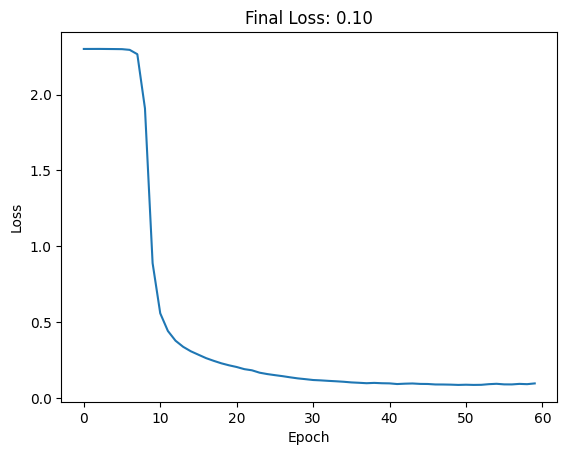

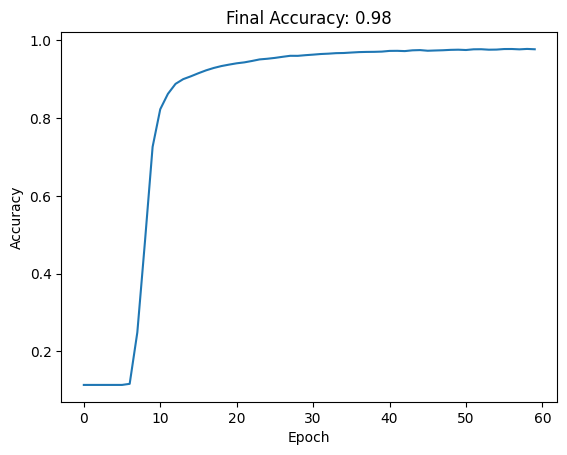

In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = 'cpu'

batch_size = 64

train, eval = load_images(batch_size)

lr = 0.1 #* 31 #* batch_size

rpu = AGADEcRamPreset()
rpu.device.fast_lr = lr 
#rpu.device.in_chop_prob = 0.001
rpu.batch_size = 16
t = [1, 1, 1]

# rpu.forward.out_noise = 0.0
# rpu.device.transfer_forward.out_noise = 0.0
# rpu.forward.is_perfect = True
rpu.update.desired_bl = 31

model = Analog_Network(rpu_config=rpu, t=t, init_std=0.02).to(device)
swa_tracker = SWATracker(model, swa_start=40, swa_freq=1)
optimizer = AnalogSGD(model.parameters(), lr=lr)
optimizer.regroup_param_groups(model)
scheduler = StepLR(optimizer, step_size=1, gamma=0.5)

loss_fn = nn.NLLLoss()

loss, accuracy = training_run(train, eval, model, swa_tracker, optimizer, scheduler, loss_fn, 60)

swa_model = swa_tracker.get_averaged_model(weighted=False)

weighted_swa_model = swa_tracker.get_averaged_model(weighted=True)


In [10]:
swa_model = swa_tracker.get_averaged_model(weighted=False)

weighted_swa_model = swa_tracker.get_averaged_model(weighted=True)

In [11]:
loss, acc = test_evaluation(model, eval, loss_fn)
print(f"Basic Final loss: {loss:.4f}, Final accuracy: {acc:.4f}")

loss, acc = test_evaluation(swa_model, eval, loss_fn)
print(f"SWA Final loss: {loss:.4f}, Final accuracy: {acc:.4f}")

loss, acc = test_evaluation(weighted_swa_model, eval, loss_fn)
print(f"Weighted SWA Final loss: {loss:.4f}, Final accuracy: {acc:.4f}")

Basic Final loss: 0.0891, Final accuracy: 0.9765
SWA Final loss: 0.0833, Final accuracy: 0.9771
Weighted SWA Final loss: 0.0828, Final accuracy: 0.9777
